In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from numba import jit, prange # to speed up

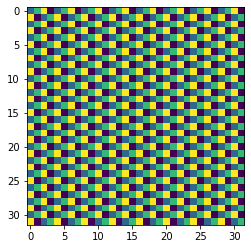

In [132]:
n = 32
periodic = True
neuron_indexes = np.arange(0, n*n, 1)
x_loc = neuron_indexes%n
y_loc = neuron_indexes//n
X = np.stack([x_loc, y_loc], 1)
thetas = [0, np.pi/2, np.pi, -np.pi/2] # W N E S
theta_pref = np.array([thetas*(n//4), thetas[2:] + thetas*(n//4 - 1) + thetas[:2]]*(n//2))
plt.imshow(theta_pref)
plt.show()

In [150]:
a=1
lbd_net = 30
beta = 3/lbd_net**2
gamma = 1.25*beta # il faut augmenter ce rapport pour garder des ilots quand on reduit le nombre de neurones
l=0.2


def norm2(x):
    return np.sum(x**2, -1)
    
def w0(x, a, gamma=gamma, beta=beta):
    xx = norm2(x)
    return a*(np.exp(-gamma*xx)-np.exp(-beta*xx))

vec_pref = np.stack([np.cos(theta_pref.flatten()), np.sin(theta_pref.flatten())], 1) # prefered direction unit vector

# Recurrent weight matrix

def W_mat(X, n, vec_pref, periodic = False, a=a, gamma=gamma, beta=beta):
    n = len(theta_pref)
    
    X_diff = np.abs(X[:, np.newaxis, :] - X[np.newaxis, :, :] - l * vec_pref[:, np.newaxis, :]) # distance h, v entre tous les points + shift

    if periodic : 
        X_diff =  np.minimum(X_diff, n-X_diff)
        
    W = w0(x=X_diff.reshape(-1, X.shape[-1]), a=a, beta=beta, gamma=gamma).reshape(n*n, n*n) 
    return W

W = W_mat(X, n, vec_pref, periodic = True)

In [181]:
gamma, beta

(0.004166666666666667, 0.0033333333333333335)

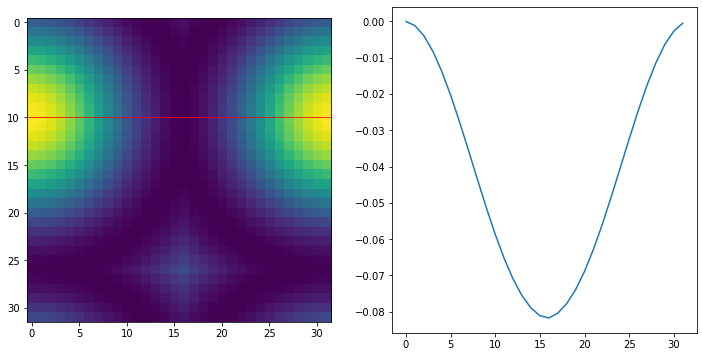

In [151]:
idx = 320

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].imshow(W[idx].reshape(n, n))
ax[0].axhline(idx//n, c= 'red', lw = 0.8)
ax[1].plot(W[idx].reshape(n, n)[idx//n , :])
plt.show()


In [177]:
a0=4
R=n
dr=n
XX =  norm2(X - n/2)

if periodic : 
    A = 1
else : 
    A = ( XX < R - dr ) * 1 + ( XX >= R - dr ) * np.exp( -a0 * (XX - R + dr)**2 / dr**2 )

alpha= 0.1

@jit(nopython = True)
def B(v, alpha=alpha):
    return A * (1 + alpha * vec_pref@v)

In [178]:
s = 0.1*np.random.random(n* n)
dt = 5E-4
tau = 1E-2 
T = 3
v = np.zeros(2)
t_array = np.arange(0, T, dt)
S = np.zeros((int(T/dt), n*n))
S[0] = s

@jit(nopython=True)
def simulate(S, W, v, dt, tau, steps):
    for t in range(steps - 1):
        inp = (W @ S[t] + B(v))
        S[t + 1] = S[t] + dt / tau * (-S[t] + (inp * (inp>0)))
    return S

S = simulate(S, W, v, dt, tau, int(T/dt))

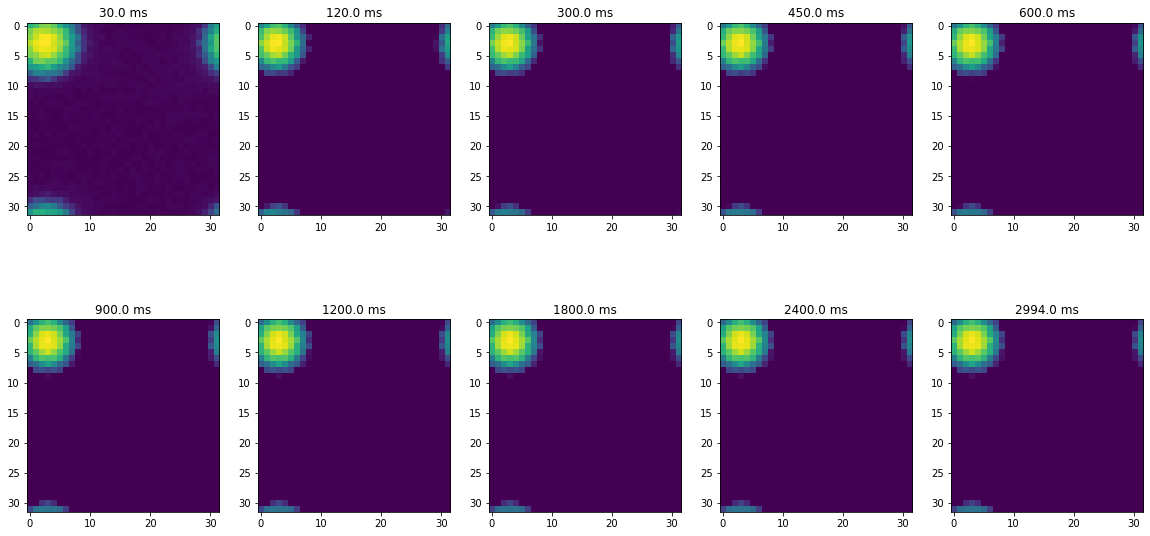

In [179]:
fig, ax = plt.subplots(2, 5, figsize = (20, 10))
times = 12*np.array([5, 20, 50, 75, 100, 150, 200, 300, 400, 499,])
for k, t in enumerate(times):
    ax[k//5, k%5].imshow(S[t, :].reshape(n, n))
    ax[k//5, k%5].set_title(f"{t*1000*dt} ms")

plt.show()

In [174]:
equilibrium_state = S[-1]
v=np.array([2, 0.], dtype = float)
T=30

speed_traj = np.zeros((int(T/dt), n*n))
speed_traj[0] = equilibrium_state
speed_traj = simulate(speed_traj, W, v, dt, tau, int(T/dt))

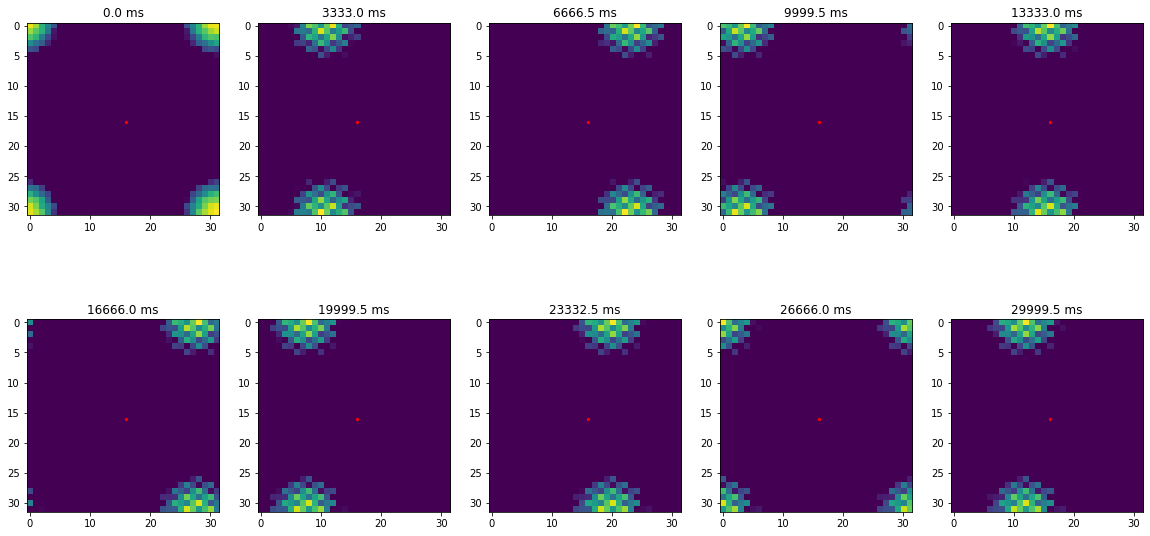

In [175]:
fig, ax = plt.subplots(2, 5, figsize = (20, 10))
times = np.linspace(0, T/dt -1, 10, dtype = 'int')
for k, t in enumerate(times):
    ax[k//5, k%5].imshow(speed_traj[t, :].reshape(n, n))
    ax[k//5, k%5].scatter(n/2, n/2, c = 'red', s=5)
    ax[k//5, k%5].set_title(f"{t*1000*dt} ms")

plt.show()

In [176]:
x = speed_traj - speed_traj.mean(0)
c = x.T @ x
eigval, eigvec = np.linalg.eig(c)

In [158]:
eigvec.shape

(1024, 1024)

In [159]:
reduced = x@eigvec[:, :4]

/var/folders/6_/x78gg4gd7cz_rjvgh5qr_xy80000gs/T/ipykernel_4013/4138894203.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  ax.scatter(xs = reduced[:, 0].astype('float'), ys = reduced[:, 1].astype('float'), zs = reduced[:, 2].astype('float'), c = reduced[:, 3].astype('float'), s=1)


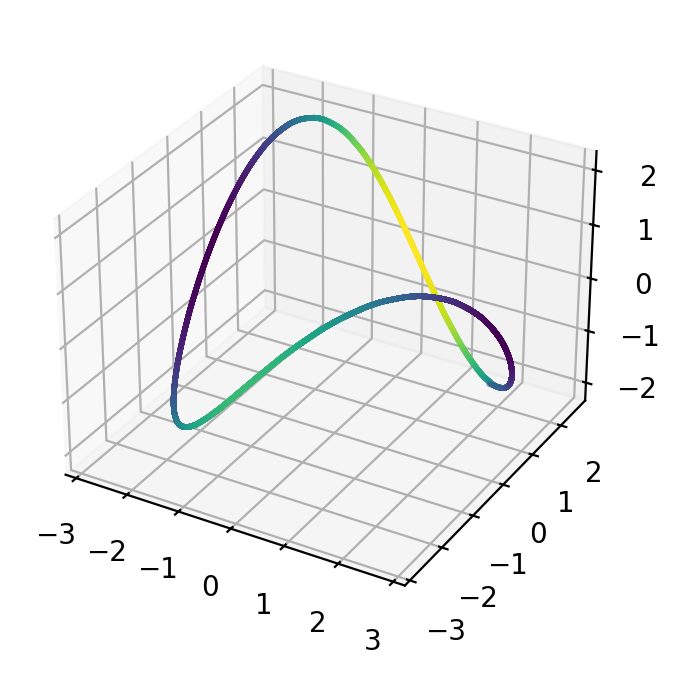

In [170]:
fig = plt.figure(dpi = 200)
ax = fig.add_subplot(projection='3d')
ax.scatter(xs = reduced[:, 0].astype('float'), ys = reduced[:, 1].astype('float'), zs = reduced[:, 2].astype('float'), c = reduced[:, 3].astype('float'), s=1)

/var/folders/6_/x78gg4gd7cz_rjvgh5qr_xy80000gs/T/ipykernel_4013/1312915223.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  ax.scatter(xs = reduced[:, 0].astype('float'), ys = reduced[:, 1].astype('float'), zs = reduced[:, 2].astype('float'), c = reduced[:, 3].astype('float'), s=1)


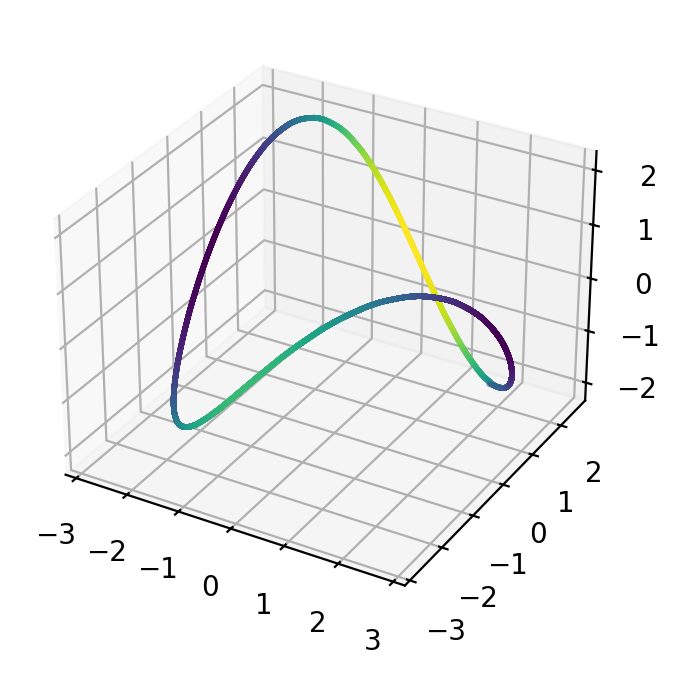

In [171]:
equilibrium_state = S[-1]
v=np.array([0., 2.], dtype = float)
T=10

speed_traj = np.zeros((int(T/dt), n*n))
speed_traj[0] = equilibrium_state
speed_traj = simulate(speed_traj, W, v, dt, tau, int(T/dt))

x = speed_traj - speed_traj.mean(0)
c = x.T @ x
eigval, eigvec = np.linalg.eig(c)

reduced = x@eigvec[:, :4]

fig = plt.figure(dpi = 200)
ax = fig.add_subplot(projection='3d')
ax.scatter(xs = reduced[:, 0].astype('float'), ys = reduced[:, 1].astype('float'), zs = reduced[:, 2].astype('float'), c = reduced[:, 3].astype('float'), s=1)

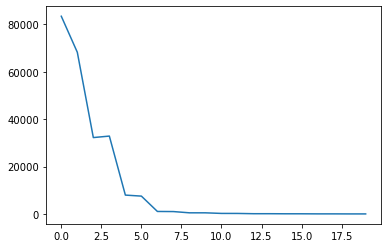

In [169]:
plt.plot(eigval[:20])